In [1]:
from IPython.display import Image
from keras.models import Model
from keras.utils import plot_model
from keras.layers import Conv2D, MaxPooling2D, Input, concatenate

Using TensorFlow backend.


# Neural Network Architectures

Deep neural networks, a.k.a Deep Learning are powerful and popular algorithms. And a lot of their success lays in the careful design of the neural network architecture. The following graph is quite representative figure that reports the top-1 accuracy versus amount of operations required for a single forward pass amongst multiple popular neural network architectures.

<img src=image/architecture.png width=500 height=400>


## VGG

The [VGG network architecture](https://arxiv.org/pdf/1409.1556.pdf) consists of 3 standard layers that forms a convolutional layer, including convolution layers to extract images' spatial features, pooling layers to subsample the feature size and relu activation function that introduces non-linearity. The following table depicts the overall architecture, where column D is referred to as VGG-16, and column E is VGG-19.

<img src=image/vgg.jpg width=500 height=400>

The architecture was the first to use much smaller 3×3 filters in each convolutional layers and also combined them as a sequence of convolutions. The insight from VGG is that multiple 3×3 convolution in sequence can emulate the effect of larger receptive fields, for examples 5×5 and 7×7, while reducing the number of parameters in the network and introducing more non-linearities. To be explicit about reducing the number of parameters part, suppose we assume that both the input and the output of a three-layer 3 × 3 convolution stack has $C$ channels, the stack is parametrised by $3 \times (3^2C^2) = 27C^2$ weights. At the same time, a single 7 × 7 conv. layer would require $7^2C^2 = 49C^2$, i.e. 81% more.

This idea of using smaller filters will be also used in more recent network architectures, such as Inception and ResNet. The downside of the VGG is that it is very expensive to evaluate and uses a lot more memory and parameters. Most of these parameters are in the first fully connected (FC) layer, and it was since found that these FC layers can be removed with no performance downgrade, significantly reducing the number of necessary parameters.

## Inception

Deep learning models were becoming extermely useful in categorizing the content of images. Given the usefulness of these techniques, the internet giants like Google were very interested in efficient and large deployments of architectures. Thus, the [Inception Net](https://arxiv.org/pdf/1409.4842.pdf) came along with the aim of reducing the computational burden of deep neural nets while obtaining state-of-art performance (on ImageNet, for example). The main difference of this architecture is the Inception module:

<img src=image/inception1.png width=500 height=500>

which at a first glance is basically the parallel combination of 1x1, 3x3 and 5x5 convolutional filters. But the great insight of the inception module was the use of 1x1 convolutional blocks to reduce the number of features before passing the data to expensive convolutional modules (i.e. the 3x3 and 5x5 convolutional filters in the image above). This is commonly referred as the "bottleneck" layer. This led to large savings in computational cost and the success of this architecture.

Let's examine this in detail. Suppose we have 256 features coming in and 256 coming out and the Inception layer only performs 3x3 convolutions. That is 256x256 x 3x3 convolutions that have to be performed (around 589,824 operations). Instead of doing this, we decide to reduce the number of features that will have to be convolved, say to 64 or 256/4. In this case, we first perform 256 -> 64 1x1 convolutions, then 64 convolution on all Inception branches, and we then use a 1x1 convolution to go from 64 -> 256 features back again. The operations are now:

- 256 x 64 x 1 x 1 = 16,000
- 64 x 64 x 3 x 3 = 36,000
- 64 x 256 x 1 x 1 = 16,000

This results in a total of about 70,000 versus the almost 600,000 we had before. Almost 10x less operations! And although we are doing less operations, we are not losing generality in this layer. In fact the bottleneck layers have been proven to perform at state-of-art on the ImageNet dataset, for example, and will be also used in later architectures such as ResNet.

In sum, the reason for the success is that the input features are correlated, and thus redundancy can be removed by combining them appropriately with the 1x1 convolutions. Then, after this dimension reduction step, they can be expanded again into meaningful combination for the next layer.

The following image is another way of viewing it:

<img src=image/inception2.png width=500 height=500>

By concatenating the features from the 3x3, 5x5 and 1x1 convolution branch, the network is indirectly going deep because we are adding more features (side note, in machine learning terminology, going wide is often referred to as adding more data to the training). And the following section also contains a simple implementation using keras.

In [3]:
# input shape is [image height, image width, number of features/filters]
input_img = Input(shape = (299, 299, 256))

branch1 = Conv2D(64, (1, 1), padding = 'same', activation = 'relu')(input_img)

# 1 x 1 convolution before applying bigger convolution
branch2 = Conv2D(64, (1, 1), padding = 'same', activation = 'relu')(input_img)
branch2 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(branch2)
branch3 = Conv2D(64, (1, 1), padding = 'same', activation = 'relu')(input_img)
branch3 = Conv2D(64, (5, 5), padding = 'same', activation = 'relu')(branch3)

branch4 = MaxPooling2D((3, 3), strides = (1, 1), padding = 'same')(input_img)
branch4 = Conv2D(64, (1, 1), padding = 'same', activation = 'relu')(branch4)

# concatenate all four branches
outputs = concatenate([branch1, branch2, branch3, branch4], axis = 3)
model = Model(inputs = input_img, outputs = outputs) 
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 299, 299, 256) 0                                            
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 299, 299, 64)  16448                                        
____________________________________________________________________________________________________
conv2d_4 (Conv2D)                (None, 299, 299, 64)  16448                                        
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 299, 299, 256) 0                                            
___________________________________________________________________________________________

We can observe from the output shape of the concatenated layer that the feature is concatenated together by stacking the channels. And we can use use keras' `plot_model` utility function to visualize the architecture. In case you get an error of failed to import pydot try the following fix:

```bash
pip install pydot-ng
brew install graphviz

# Reference
# https://github.com/fchollet/keras/issues/3210#issuecomment-278197527
```

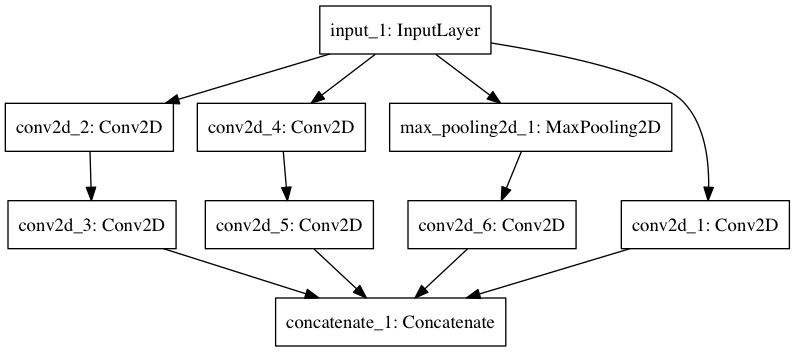

In [4]:
model_image = 'inception_model.png'
plot_model(model, to_file = model_image)
Image(filename = model_image) 

In [5]:
# next, we can observe the number of parameters
# required without doing the 1x1 convolution
input_img = Input(shape = (299, 299, 256))

branch1 = Conv2D(64, (1, 1), padding = 'same', activation = 'relu')(input_img)

# directly applying bigger convolution
branch2 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(input_img)
branch3 = Conv2D(64, (5, 5), padding = 'same', activation = 'relu')(input_img)

branch4 = MaxPooling2D((3, 3), strides = (1, 1), padding = 'same')(input_img)
branch4 = Conv2D(64, (1, 1), padding = 'same', activation = 'relu')(branch4)

# concatenate all four branches
outputs = concatenate([branch1, branch2, branch3, branch4], axis = 3)
model = Model(inputs = input_img, outputs = outputs)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 299, 299, 256) 0                                            
____________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)   (None, 299, 299, 256) 0                                            
____________________________________________________________________________________________________
conv2d_7 (Conv2D)                (None, 299, 299, 64)  16448                                        
____________________________________________________________________________________________________
conv2d_8 (Conv2D)                (None, 299, 299, 64)  147520                                       
___________________________________________________________________________________________

# Reference

- [Keras Documentation: Inception module](https://github.com/fchollet/keras/blob/master/docs/templates/getting-started/functional-api-guide.md#inception-module)
- [Blog: Neural Network Architectures](https://medium.com/towards-data-science/neural-network-architectures-156e5bad51ba)
- [Blog: One by One [ 1 x 1 ] Convolution - counter-intuitively useful](http://iamaaditya.github.io/2016/03/one-by-one-convolution/)